In [1]:
from abc import ABC, abstractmethod


class SpaceFillingCurve(ABC):
    def __init__(self, nx, ny):
        self.nx = nx
        self.ny = ny

    @abstractmethod
    def ixiy2p(self, ix, iy):
        ...

    @abstractmethod
    def p2ixiy(self, p):
        ...

    def ixiy_correct(self, ix, iy):
        assert ix != None and iy != None, "both ix and iy must be specified"
        assert ix >= 0 and ix < self.nx, "ix out of range"
        assert iy >= 0 and iy < self.ny, "iy out of range"

    def p_correct(self, p):
        assert p != None, "p must be specified"
        assert p >= 0 and p < self.nx * self.ny, "p out of range"

    def draw(self, ax=None, cmap="turbo", norm=abs, locality=True):
        import matplotlib.pyplot as plt
        import matplotlib as mpl

        scale = mpl.colors.LogNorm(vmin=0.01, vmax=1)

        if ax is None:
            ax = plt.gca()
        for p in range(self.nx * self.ny):
            ix1, iy1 = self.p2ixiy(p)
            if p < self.nx * self.ny - 1:
                ix2, iy2 = self.p2ixiy(p + 1)
                ax.plot(
                    [ix1 + 0.5, ix2 + 0.5],
                    [iy1 + 0.5, iy2 + 0.5],
                    c="w",
                    zorder=1,
                    lw=1,
                )
            if locality:
                loc = self.locality(ix1, iy1)
                ax.scatter(
                    [ix1 + 0.5],
                    [iy1 + 0.5],
                    c=[mpl.colormaps[cmap](scale(loc))],
                    zorder=2,
                    s=5,
                    linewidth=0.5,
                    edgecolors="w",
                )
        if locality:
            loc = self.locality(norm=norm)
        ax.set(
            xlim=(0, self.nx),
            ylim=(0, self.ny),
            xticks=[],
            yticks=[],
            aspect="equal",
            title=rf"$L={{{loc:.3f}}}$" if locality else None,
        )
        # if locality:
        #     sm = plt.cm.ScalarMappable(cmap=mpl.colormaps[cmap], norm=scale)
        #     sm.set_array([])
        #     cbar = plt.colorbar(sm, ax=ax)

    def locality(self, ix=None, iy=None, norm=abs):
        loc = 0
        if ix is None or iy is None:
            for p in range(self.nx * self.ny):
                ix, iy = self.p2ixiy(p)
                loc += self.locality(ix, iy, norm)
            loc /= self.nx * self.ny
        else:
            self.ixiy_correct(ix, iy)
            p0 = self.ixiy2p(ix, iy)
            loc = (
                norm(self.ixiy2p((ix - 1) % self.nx, iy) - p0) / 6
                + norm(self.ixiy2p((ix + 1) % self.nx, iy) - p0) / 6
                + norm(self.ixiy2p(ix, (iy - 1) % self.ny) - p0) / 6
                + norm(self.ixiy2p(ix, (iy + 1) % self.ny) - p0) / 6
                + norm(self.ixiy2p((ix - 1) % self.nx, (iy - 1) % self.ny) - p0) / 12
                + norm(self.ixiy2p((ix + 1) % self.nx, (iy - 1) % self.ny) - p0) / 12
                + norm(self.ixiy2p((ix - 1) % self.nx, (iy + 1) % self.ny) - p0) / 12
                + norm(self.ixiy2p((ix + 1) % self.nx, (iy + 1) % self.ny) - p0) / 12
            ) / (self.nx * self.ny)
            assert loc <= 1, f"locality must be <= 1: {ix} {iy} => {loc}"
        return loc


class Cartesian(SpaceFillingCurve):
    def ixiy2p(self, ix, iy):
        self.ixiy_correct(ix, iy)
        return ix + iy * self.nx

    def p2ixiy(self, p):
        self.p_correct(p)
        return p % self.nx, p // self.nx


class Snake(SpaceFillingCurve):
    def ixiy2p(self, ix, iy):
        self.ixiy_correct(ix, iy)
        return ix + iy * self.nx if iy % 2 == 0 else (self.nx - ix - 1) + iy * self.nx

    def p2ixiy(self, p):
        self.p_correct(p)
        return (
            (p % self.nx, p // self.nx)
            if (p // self.nx) % 2 == 0
            else (
                self.nx - p % self.nx - 1,
                p // self.nx,
            )
        )


class Random(SpaceFillingCurve):
    def __init__(self, nx, ny, seed=0):
        import numpy as np

        super().__init__(nx, ny)
        self.seed = seed
        self.random = np.random.RandomState(seed)
        self.perm = self.random.permutation(nx * ny)
        self.invperm = np.argsort(self.perm)

    def ixiy2p(self, ix, iy):
        self.ixiy_correct(ix, iy)
        return self.perm[ix + iy * self.nx]

    def p2ixiy(self, p):
        self.p_correct(p)
        return self.invperm[p] % self.nx, self.invperm[p] // self.nx


class Morton(SpaceFillingCurve):
    def __init__(self, nx: int, ny: int):
        assert nx & (nx - 1) == 0, "nx must be power of 2"
        assert ny & (ny - 1) == 0, "ny must be power of 2"
        super().__init__(nx, ny)

    def ixiy2p(self, ix, iy):
        self.ixiy_correct(ix, iy)
        return self._morton(ix, iy, self.nx, self.ny)

    def p2ixiy(self, p):
        self.p_correct(p)
        return self._morton_inv(p, self.nx, self.ny)

    def _morton(self, ix, iy, nx, ny):
        if nx == 1 and ny == 1:
            return 0
        nx2 = nx // 2
        ny2 = ny // 2
        if ix < nx2 and iy < ny2:
            return self._morton(ix, iy, nx2, ny2)
        elif ix < nx2 and iy >= ny2:
            return nx2 * ny2 + self._morton(ix, iy - ny2, nx2, ny2)
        elif ix >= nx2 and iy < ny2:
            return 2 * nx2 * ny2 + self._morton(ix - nx2, iy, nx2, ny2)
        elif ix >= nx2 and iy >= ny2:
            return 3 * nx2 * ny2 + self._morton(ix - nx2, iy - ny2, nx2, ny2)
        else:
            raise RuntimeError("should not happen")

    def _morton_inv(self, p, nx, ny):
        if nx == 1 and ny == 1:
            return 0, 0
        nx2 = nx // 2
        ny2 = ny // 2
        if p < nx2 * ny2:
            ix, iy = self._morton_inv(p, nx2, ny2)
            return ix, iy
        elif p < 2 * nx2 * ny2:
            ix, iy = self._morton_inv(p - nx2 * ny2, nx2, ny2)
            return ix, iy + ny2
        elif p < 3 * nx2 * ny2:
            ix, iy = self._morton_inv(p - 2 * nx2 * ny2, nx2, ny2)
            return ix + nx2, iy
        elif p < 4 * nx2 * ny2:
            ix, iy = self._morton_inv(p - 3 * nx2 * ny2, nx2, ny2)
            return ix + nx2, iy + ny2
        else:
            raise RuntimeError("should not happen")


class Hilbert(SpaceFillingCurve):
    def __init__(self, nx: int, ny: int):
        import numpy as np

        assert nx & (nx - 1) == 0, "nx must be power of 2"
        assert ny & (ny - 1) == 0, "ny must be power of 2"
        self.r = int(np.log2(nx))
        super().__init__(nx, ny)

    def ixiy2p(self, ix: int, iy: int) -> int:
        assert ix >= 0 and ix < self.nx, "ix out of range"
        assert iy >= 0 and iy < self.ny, "iy out of range"

        def interleave(even: str, odd: str) -> str:
            return "".join([e + o for e, o in zip(even, odd)])

        mask = (1 << self.r) - 1
        peven = ix ^ iy
        notx = ~ix & mask
        noty = ~iy & mask
        temp = notx ^ iy
        v1 = 0
        v0 = 0
        for _ in range(self.r - 1):
            v1 = ((v1 & peven) | ((v0 ^ noty) & temp)) >> 1
            v0 = ((v0 & (v1 ^ notx)) | (~v0 & (v1 ^ noty))) >> 1
        podd = (~v0 & (v1 ^ ix)) | (v0 & (v1 ^ noty))
        return int(
            interleave(bin(podd)[2:].zfill(self.r), bin(peven)[2:].zfill(self.r)), 2
        )

    def p2ixiy(self, p: int) -> tuple:
        def deleave(pp: int):
            p_bin = bin(pp)[2:].zfill(2 * self.r)
            return (int(p_bin[1::2], 2), int(p_bin[::2], 2))

        peven, podd = deleave(p)
        mask = (1 << self.r) - 1
        v1 = 0
        v0 = 0
        temp1 = ~(peven | podd) & mask
        temp0 = ~(peven ^ podd) & mask
        for _ in range(self.r - 1):
            v1 = (v1 ^ temp1) >> 1
            v0 = (v0 ^ temp0) >> 1
        ix = (v0 & (~peven)) ^ v1 ^ podd
        iy = (v0 | peven) ^ v1 ^ podd
        return ix, iy

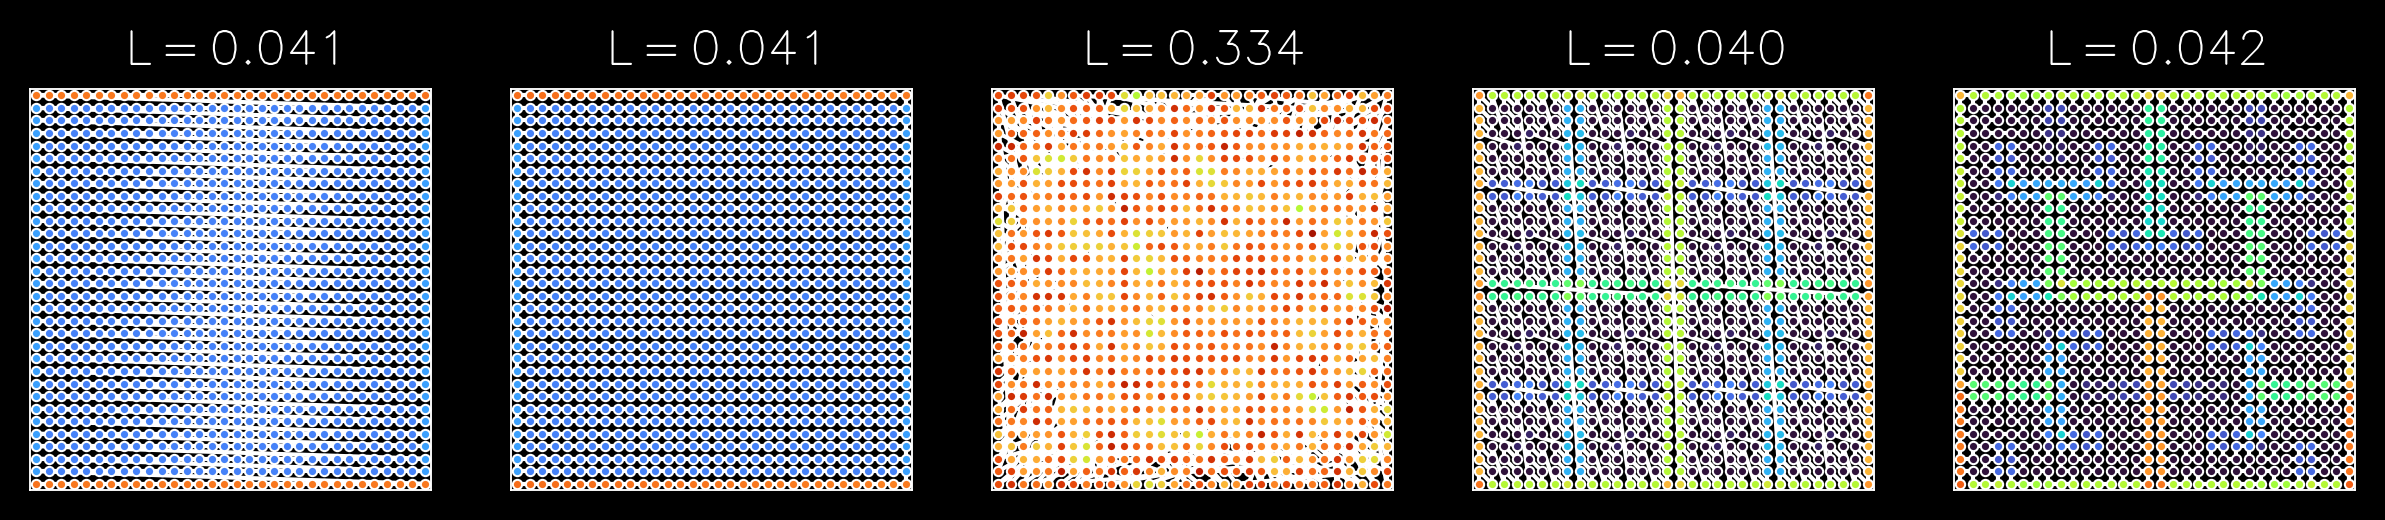

In [2]:
import matplotlib.pyplot as plt
import myplotlib 
myplotlib.load("hershey", "dark")

nx, ny = 32, 32

fig = plt.figure(figsize=(10, 2), dpi=300)
ax1, ax2, ax3, ax4, ax5 = fig.subplots(1, 5)
cart = Cartesian(nx, ny)
snake = Snake(nx, ny)
random = Random(nx, ny, seed=0)
morton = Morton(nx, ny)
hilbert = Hilbert(nx, ny)
cart.draw(ax1)
snake.draw(ax2)
random.draw(ax3)
morton.draw(ax4)
hilbert.draw(ax5)